In [2]:
import pandas as pd
import numpy as  np
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [3]:
rawdata = pd.read_csv("data/raw/LifeExpectancyData.csv")
# Options for missing features - dropna(), drop(), fillna()
# drop the missing values from our target value
data = rawdata.dropna(axis=0, subset=['Life expectancy'])
data.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                      0
Adult Mortality                      0
infant deaths                        0
Alcohol                            193
percentage expenditure               0
Hepatitis B                        553
Measles                              0
BMI                                 32
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
HIV/AIDS                             0
GDP                                443
Population                         644
thinness  1-19 years                32
thinness 5-9 years                  32
Income composition of resources    160
Schooling                          160
dtype: int64

In [4]:
# Now we can impute missing values for numerical attributes with fillna() 
# compute the median/mean value on the data and use that to fill the missing values 
# We are also missing 21% of observations for "population" so figure out how to handle this later

# NOTE: Cannot do this with categoricals, so drop them first. 
num_only_df = data.drop(["Country", "Status"], axis=1)
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(num_only_df)
imputed_df = pd.DataFrame(X, columns=num_only_df.columns)  # Now we can put this back into a DataFrame


In [5]:
# Now, we can handle the categorical values, "Country" and "Status"
# We could do this manually, but instead we will use sklearn LabelEncoder and OneHotEncoder
# Do "Country" first, we must convert text labels to numbers
lbl_encoder = LabelEncoder()
country = data["Country"]
country_encoded = lbl_encoder.fit_transform(country)

# Now we can convert this into a vector 
oh_encoder = OneHotEncoder()
# must use reshape to get 2d array from 1d (country_ef_encoded)
# reshape() -1 argument means "unspecified", ie it's inferred from len of array and remaining dimensions
# We use toarray() to create a smaller data structure that only stores the location of the nonzero element,
# instead of a sparse matrix with a bunch of zeroes
country_oh = oh_encoder.fit_transform(country_encoded.reshape(-1,1)).toarray()

# We can do the previous labeling/encoding in one step with LabelBinarizer() 
# status = data["Status"]
# status_encoder = LabelBinarizer()
# status_oh = status_encoder.fit_transform(status)
# country_oh.shape
status_encoder = LabelEncoder()
status = data["Status"]
status_encoded = status_encoder.fit_transform(status)
np.unique(status_encoded)


array([0, 1])

In [6]:
country_df = pd.DataFrame(data=country_oh[:,:], columns=country_oh[0,:])
#axis=1 will stack the columns in the second DataFrame to the RIGHT of the first DataFrame
final_df = pd.concat([imputed_df, country_df], axis=1)
# final_df['status'] = status_encoded
final_df.insert(2,'status', status_encoded)

final_df.rename(columns={'Year': 'year', 'Life expectancy': 'life-expectancy', 'Adult Mortality': 'adult-mortality', 'infant deaths': 'infant-deaths',
                         'Alcohol': 'alcohol', 'percentage expenditure': 'expenditure-GDP', 'Hepatitis B': 'hep-B', 'Measles': 'meales-cases','under-five deaths': 'under-5-deaths',
                         'Polio': 'polio-immunizations', 'Total expenditure': 'expentidure-total','Diphtheria ': 'diphtheria -immunizations', 'thinness  1-19 years': 'thinness-10to19',
                         'thinness 5-9 years': 'thinness-5to9', 'Income composition of resources': 'income-composition', 'Schooling': 'schooling' }, 
                inplace=True)

final_df.columns



Index([           'year', 'life-expectancy',          'status',
       'adult-mortality',   'infant-deaths',         'alcohol',
       'expenditure-GDP',           'hep-B',    'meales-cases',
                   'BMI',
       ...
                     0.0,               0.0,               0.0,
                     0.0,               0.0,               0.0,
                     0.0,               0.0,               0.0,
                     0.0],
      dtype='object', length=204)

In [7]:
old_corr_matrix = data.corr()
old_corr_matrix["Life expectancy"]

Year                               0.170033
Life expectancy                    1.000000
Adult Mortality                   -0.696359
infant deaths                     -0.196557
Alcohol                            0.404877
percentage expenditure             0.381864
Hepatitis B                        0.256762
Measles                           -0.157586
BMI                                0.567694
under-five deaths                 -0.222529
Polio                              0.465556
Total expenditure                  0.218086
Diphtheria                         0.479495
HIV/AIDS                          -0.556556
GDP                                0.461455
Population                        -0.021538
thinness  1-19 years              -0.477183
thinness 5-9 years                -0.471584
Income composition of resources    0.724776
Schooling                          0.751975
Name: Life expectancy, dtype: float64

In [8]:
corr_matrix = final_df.corr()
# corr_matrix.iloc[:21,1]
corr_matrix



,year,life-expectancy,status,adult-mortality,infant-deaths,alcohol,expenditure-GDP,hep-B,meales-cases,BMI,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
year,1.000000e+00,0.170033,0.000000,-0.079052,-0.036464,-0.044669,0.032723,0.090739,-0.081840,0.104094,...,2.670877e-18,2.670877e-18,2.670877e-18,2.670877e-18,2.670877e-18,2.670877e-18,2.670877e-18,2.670877e-18,2.670877e-18,2.677851e-18
life-expectancy,1.700330e-01,1.000000,-0.482136,-0.696359,-0.196557,0.392420,0.381864,0.204566,-0.157586,0.562453,...,-1.028995e-01,6.879517e-02,5.332367e-02,-9.292096e-03,1.683430e-02,3.240310e-02,4.320395e-02,-4.174331e-02,-1.192467e-01,-1.458597e-01
status,0.000000e+00,-0.482136,1.000000,0.315284,0.112708,-0.579438,-0.454032,-0.095800,0.077320,-0.314723,...,3.412328e-02,-1.610192e-01,3.412328e-02,3.412328e-02,3.412328e-02,3.412328e-02,3.412328e-02,3.412328e-02,3.412328e-02,3.412328e-02
adult-mortality,-7.905159e-02,-0.696359,0.315284,1.000000,0.078756,-0.190791,-0.242860,-0.139146,0.031176,-0.383641,...,8.329293e-02,-6.358998e-02,-2.675741e-02,1.193915e-02,-1.605807e-02,-1.071543e-03,-2.280574e-02,2.804408e-02,1.130423e-01,1.774993e-01
infant-deaths,-3.646405e-02,-0.196557,0.112708,0.078756,1.000000,-0.114806,-0.085906,-0.179724,0.501038,-0.227427,...,4.070011e-02,-2.648758e-03,-1.873295e-02,-5.316381e-03,-1.908602e-02,-1.320156e-02,-7.657303e-04,5.628718e-03,1.901892e-03,-2.413380e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.0,2.670877e-18,0.032403,0.034123,-0.001072,-0.013202,0.049801,-0.027568,-0.048405,-0.014606,0.060699,...,-5.494505e-03,-5.494505e-03,-5.494505e-03,-5.494505e-03,-5.494505e-03,1.000000e+00,-5.494505e-03,-5.494505e-03,-5.494505e-03,-5.494505e-03
0.0,2.670877e-18,0.043204,0.034123,-0.022806,-0.000766,-0.027119,-0.027568,0.017585,0.011651,-0.101020,...,-5.494505e-03,-5.494505e-03,-5.494505e-03,-5.494505e-03,-5.494505e-03,-5.494505e-03,1.000000e+00,-5.494505e-03,-5.494505e-03,-5.494505e-03
0.0,2.670877e-18,-0.041743,0.034123,0.028044,0.005629,-0.081090,-0.027568,-0.083160,0.002152,-0.017733,...,-5.494505e-03,-5.494505e-03,-5.494505e-03,-5.494505e-03,-5.494505e-03,-5.494505e-03,-5.494505e-03,1.000000e+00,-5.494505e-03,-5.494505e-03
0.0,2.670877e-18,-0.119247,0.034123,0.113042,0.001902,-0.042174,-0.024229,-0.025207,0.026696,-0.077630,...,-5.494505e-03,-5.494505e-03,-5.494505e-03,-5.494505e-03,-5.494505e-03,-5.494505e-03,-5.494505e-03,-5.494505e-03,1.000000e+00,-5.494505e-03


Text(0.5, 1.05, 'Correlation Matrix')

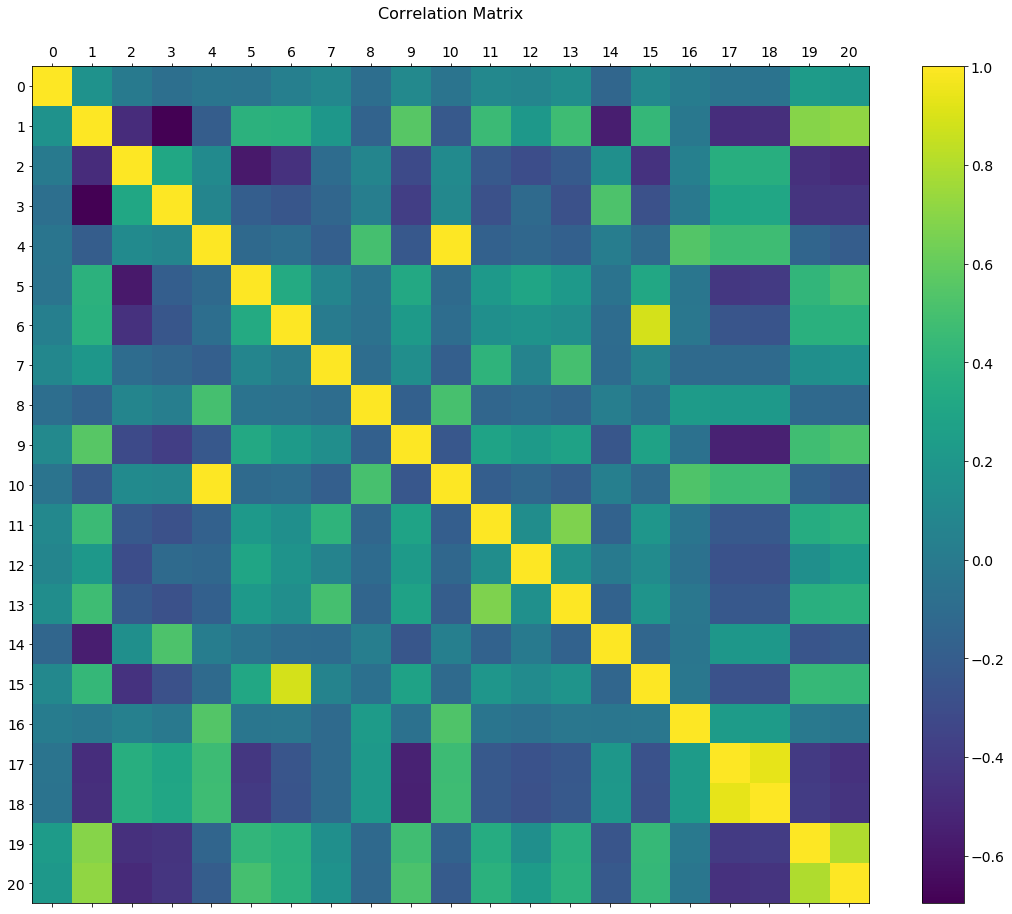

In [9]:
# Plotting correlation matrix

# numerical_features = final_df.iloc[:, 0:21]
# corr_matrix = numerical_features.corr()
# corr_matrix["life-expectancy"].sort_values()
# corr_matrix
# #
# correlations = plt.figure(figsize=(19,15))
# plt.matshow(corr_matrix, fignum=correlations.number)
# plt.xticks(range(corr_matrix.shape[1]), fontsize=14)
# plt.yticks(range(corr_matrix.shape[1]), fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
# plt.title("Correlation Matrix", fontsize=16)

In [10]:
# define our attributes as X and independent variables as y (life expectancy)

X = final_df.drop("life-expectancy", axis=1)
y = final_df.iloc[:, 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
# Now we can train the algorithm

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
# 
# for i, col_name in enumerate(X_train.columns):
#     # print("col name: ", col_name)
#     # print("coeff: ", linear_model.coef_)
#     print("The coefficient for {} is: {}".format(col_name, linear_model.coef_[i]))





LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [12]:
y_predict = linear_model.predict((X_test))

predictions_results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_predict})
predictions_results_df


,Actual,Predicted
2390,56.5,57.464705
196,73.0,70.586345
2307,82.5,82.679642
1731,75.6,77.046252
1100,53.0,54.350887
...,...,...
2443,69.1,72.566177
381,74.8,74.899201
1780,65.6,65.778162
962,66.0,60.567825
